# SENTIMENT ANALYSIS OF IPHONE 17 REDDIT POSTS USING NLP


Importing Libraries

In [1]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob       #Text and Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

nltk.download('stopwords')   #Downloading NLTK Resources
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load Uploaded Dataset

In [6]:
url = "https://raw.githubusercontent.com/nc875-cpu/Sentiment-Analysis/main/iphone17_reddit__country.csv"
df = pd.read_csv(url, encoding='utf-8', on_bad_lines='skip')

print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("✅ Dataset loaded successfully!")
df.head()

Dataset shape: (1000, 11)
Columns: Index(['id', 'title', 'author', 'created_utc', 'score', 'upvote_ratio',
       'subreddit', 'permalink', 'url', 'language', 'country'],
      dtype='object')
✅ Dataset loaded successfully!


,id,title,author,created_utc,score,upvote_ratio,subreddit,permalink,url,language,country
0,1o047gc,Should i swap,Wolviepaws,2025-10-07T03:36:35,1,1.00,phone,https://www.reddit.com/r/phone/comments/1o047g...,https://www.reddit.com/r/phone/comments/1o047g...,en,United States
1,1o03o88,Es esto una especia de scam?,Wolframio208,2025-10-07T03:09:30,4,1.00,programacion,https://www.reddit.com/r/programacion/comments...,https://www.reddit.com/r/programacion/comments...,en,United States
2,1o00sze,Massive issue.,Lemes_GT,2025-10-07T00:53:40,34,0.73,dbrand,https://www.reddit.com/r/dbrand/comments/1o00s...,https://www.reddit.com/gallery/1o00sze,en,United States
3,1nzzujs,iPhone 17 Pro Max Timeline,tootsiebug,2025-10-07T00:09:25,0,0.40,ATT,https://www.reddit.com/r/ATT/comments/1nzzujs/...,https://www.reddit.com/r/ATT/comments/1nzzujs/...,en,United States
4,1nztof7,Iphone 17 pro max oscilando volume em músicas,Aggravating-Sun-2461,2025-10-06T20:02:40,1,1.00,iPhone17Pro,https://www.reddit.com/r/iPhone17Pro/comments/...,https://www.reddit.com/r/iPhone17Pro/comments/...,es,Spain


In [7]:
print("Column names in your dataset:")
print(list(df.columns))

Column names in your dataset:
['id', 'title', 'author', 'created_utc', 'score', 'upvote_ratio', 'subreddit', 'permalink', 'url', 'language', 'country']


Automatic column detection

In [8]:
text_col = None
country_col = None
for col in df.columns:
    low = col.lower()
    if any(k in low for k in ['text','body','post','comment','review','title']):
        if text_col is None:
            text_col = col
    if any(k in low for k in ['country','location','place','region','loc','area']):
        if country_col is None:
            country_col = col
if text_col is None:
    for col in df.columns:
        if df[col].dtype == object:
            text_col = col
            break
if country_col is None:
    for col in df.columns[::-1]:
        if df[col].dtype == object and col != text_col:
            country_col = col

print(f"Detected text column: {text_col}")
print(f"Detected country column: {country_col}")

Detected text column: title
Detected country column: country


Keeping and renaming the required columns

In [9]:
df = df.rename(columns={text_col: 'post', country_col: 'country'})
df = df[['post','country']].dropna().reset_index(drop=True)

Text pre-processing

In [10]:
simple_stopwords = {
    "a","about","above","after","again","against","all","am","an","and","any","are","as","at","be","because","been",
    "before","being","below","between","both","but","by","could","did","do","does","doing","down","during","each",
    "few","for","from","further","had","has","have","having","he","her","here","hers","herself","him","himself",
    "his","how","i","if","in","into","is","it","its","itself","just","me","more","most","my","myself","no","nor",
    "not","now","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","same",
    "she","should","so","some","such","than","that","the","their","theirs","them","themselves","then","there",
    "these","they","this","those","through","to","too","under","until","up","very","was","we","were","what",
    "when","where","which","while","who","whom","why","with","would","you","your","yours","yourself","yourselves"
}

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess(text):
    text = clean_text(text)
    words = [w for w in text.split() if w not in simple_stopwords and len(w) > 1]
    return " ".join(words)

df['clean_post'] = df['post'].apply(preprocess)

Sentiment Analysis using VADER+TEXTBLOB

In [11]:
analyzer = SentimentIntensityAnalyzer()

def hybrid_sentiment(text):
    vader_score = analyzer.polarity_scores(text)['compound']
    blob_score = TextBlob(text).sentiment.polarity
    final_score = (vader_score + blob_score) / 2
    if final_score >= 0.05:
        return 'positive'
    elif final_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_post'].apply(hybrid_sentiment)
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())


Sentiment Distribution:
sentiment
neutral     589
positive    256
negative    155
Name: count, dtype: int64


Lexicon-Based Sentiment Analysis VADER + TextBlob

In [12]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['clean_post'].apply(vader_sentiment)

In [13]:
def textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['clean_post'].apply(textblob_sentiment)

In [14]:
print("\nLexicon-Based Sentiment Counts (VADER):")
print(df['vader_sentiment'].value_counts())
print("\nLexicon-Based Sentiment Counts (TextBlob):")
print(df['textblob_sentiment'].value_counts())


Lexicon-Based Sentiment Counts (VADER):
vader_sentiment
neutral     686
positive    187
negative    127
Name: count, dtype: int64

Lexicon-Based Sentiment Counts (TextBlob):
textblob_sentiment
neutral     695
positive    205
negative    100
Name: count, dtype: int64


data prep for ML models

In [15]:
# Using the results from TextBlob as pseudo labels
df['label'] = df['textblob_sentiment']
df = df[df['label'] != 'neutral']  # keeping only positive/negative values for binary classification

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_post'])
y = df['label']

# splitting data for Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training ML models

In [16]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, pos_label='positive')
    rec = recall_score(y_test, preds, pos_label='positive')
    f1 = f1_score(y_test, preds, pos_label='positive')
    results.append([name, acc, prec, rec, f1])

ml_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nMachine Learning Results:")
print(ml_results)


Machine Learning Results:
                 Model  Accuracy  Precision  Recall  F1-Score
0          Naive Bayes  0.704918   0.694915     1.0  0.820000
1  Logistic Regression  0.672131   0.672131     1.0  0.803922
2           Linear SVM  0.721311   0.706897     1.0  0.828283


Text encoding for LSTM

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [18]:
X = df["clean_post"].values
y = df["sentiment"].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding="post", truncating="post")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_categorical, test_size=0.2, random_state=42)

Build LSTM model

In [19]:
vocab_size = 10000
embedding_dim = 128
maxlen = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

# Build the model explicitly (so summary shows params)
model.build(input_shape=(None, maxlen))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,035 (5.42 MB)

 Trainable params: 1,420,035 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

training the model

In [20]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.5846 - loss: 1.0203 - val_accuracy: 0.6327 - val_loss: 0.8768
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6000 - loss: 0.9076 - val_accuracy: 0.6327 - val_loss: 0.8257
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6000 - loss: 0.9079 - val_accuracy: 0.6327 - val_loss: 0.8276
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5949 - loss: 0.8876 - val_accuracy: 0.6327 - val_loss: 0.8374
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5744 - loss: 0.8943 - val_accuracy: 0.6327 - val_loss: 0.8348
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6000 - loss: 0.8942 - val_accuracy: 0.6327 - val_loss: 0.8241
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6000 - loss: 0.8938 - val_accuracy: 0.6327 - val_loss: 0.8260
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6103 - loss: 0.8804 - val_accuracy: 0.6327 - val_loss: 0

Evaluation of the model

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step

📊 LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        15
     neutral       0.00      0.00      0.00         7
    positive       0.64      1.00      0.78        39

    accuracy                           0.64        61
   macro avg       0.21      0.33      0.26        61
weighted avg       0.41      0.64      0.50        61



C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

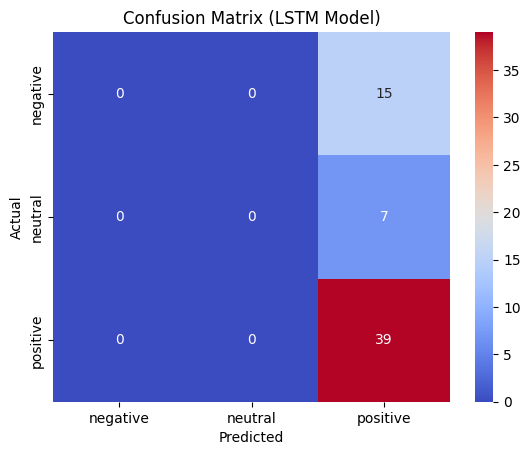

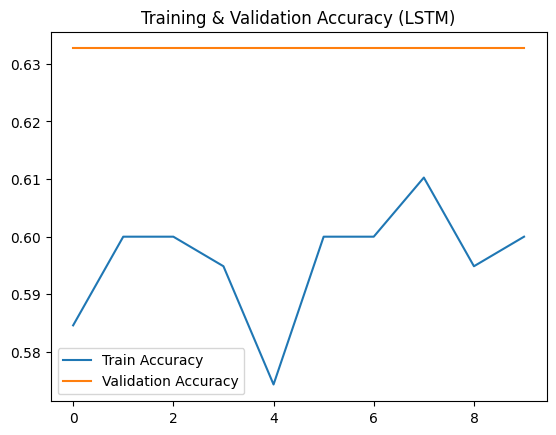

In [21]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 LSTM Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (LSTM Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy plot
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy (LSTM)")
plt.legend()
plt.show()


comparision of LSTM vs RULE BASED sentiment

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Comparison (Rule-based vs LSTM):
lstm_sentiment  positive
sentiment               
negative             1.0
neutral              1.0
positive             1.0


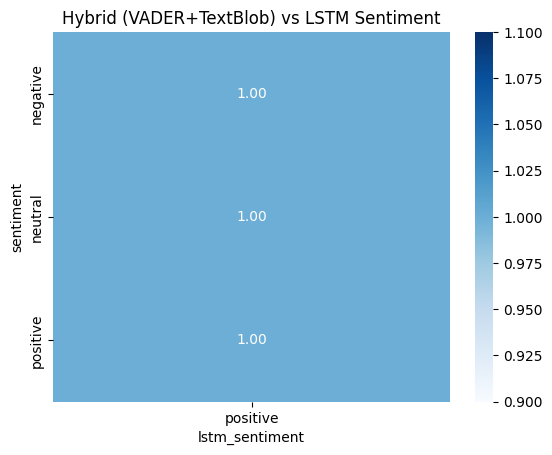

In [22]:
df["lstm_pred"] = model.predict(X_pad).argmax(axis=1)
df["lstm_sentiment"] = le.inverse_transform(df["lstm_pred"])

compare = pd.crosstab(df["sentiment"], df["lstm_sentiment"], normalize="index")
print("\nComparison (Rule-based vs LSTM):")
print(compare)

sns.heatmap(compare, annot=True, cmap="Blues", fmt=".2f")
plt.title("Hybrid (VADER+TextBlob) vs LSTM Sentiment")
plt.show()

In [23]:
country_sent = df.groupby(["country","lstm_sentiment"]).size().unstack(fill_value=0).reset_index()
country_sent["total"] = country_sent.sum(axis=1, numeric_only=True)
for s in ["positive","negative","neutral"]:
    if s not in country_sent.columns:
        country_sent[s] = 0
country_sent["positive_percent"] = country_sent["positive"] / country_sent["total"] * 100
country_sent["negative_percent"] = country_sent["negative"] / country_sent["total"] * 100
country_sent["neutral_percent"]  = country_sent["neutral"]  / country_sent["total"] * 100

fig = px.choropleth(
    country_sent, locations="country", locationmode="country names",
    color="positive_percent", hover_name="country",
    hover_data=["positive","negative","neutral"],
    color_continuous_scale="RdYlGn", title="🌍 LSTM Model: Positive Sentiment % by Country"
)
fig.show()

C:\Users\chand\AppData\Local\Temp\ipykernel_70932\2183553774.py:10: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


                                    Visualization of all the distributed sentiments

C:\Users\chand\AppData\Local\Temp\ipykernel_70932\1990841888.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




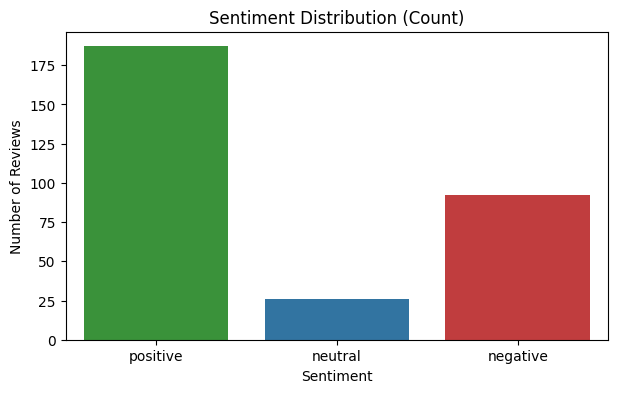

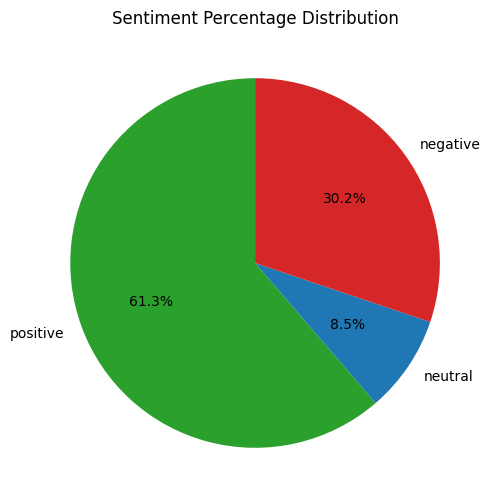

In [24]:
plt.figure(figsize=(7,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'], palette=['#2ca02c','#1f77b4','#d62728'])
plt.title('Sentiment Distribution (Count)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

plt.figure(figsize=(6,6))
df['sentiment'].value_counts().reindex(['positive','neutral','negative']).plot.pie(
    autopct='%1.1f%%', colors=['#2ca02c','#1f77b4','#d62728'], startangle=90)
plt.title('Sentiment Percentage Distribution')
plt.ylabel('')
plt.show()

frequently used words

In [25]:
def get_word_frequencies(sentiment_label):
    words = " ".join(df[df['sentiment'] == sentiment_label]['clean_post']).split()
    freq = pd.Series(words).value_counts().head(15)
    return freq

for s in ['positive','negative','neutral']:
    print(f"\nTop words in {s} reviews:")
    print(get_word_frequencies(s))


Top words in positive reviews:
iphone     160
pro         90
max         56
new         43
apple       24
first       18
best        16
phone       14
air         12
battery     11
worth       10
camera      10
one          8
better       8
like         8
Name: count, dtype: int64

Top words in negative reviews:
iphone      58
pro         41
max         22
base        11
new         10
apple        8
slow         6
ultra        5
esim         5
ios          5
random       4
confused     4
time         4
feel         4
case         4
Name: count, dtype: int64

Top words in neutral reviews:
iphone         21
pro            16
max             8
long            6
apple           4
blue            3
new             3
buying          2
deep            2
plus            2
performance     2
least           2
fix             2
models          2
faster          2
Name: count, dtype: int64


Reviews by country

In [26]:
df['country'] = df['country'].fillna('Unknown')
sentiment_counts = df.groupby(['country','sentiment']).size().unstack(fill_value=0).reset_index()
for col in ['positive','negative','neutral']:
    if col not in sentiment_counts.columns:
        sentiment_counts[col] = 0
sentiment_counts['total'] = sentiment_counts[['positive','negative','neutral']].sum(axis=1)
sentiment_counts['positive_percent'] = (sentiment_counts['positive'] / sentiment_counts['total'])*100
sentiment_counts['negative_percent'] = (sentiment_counts['negative'] / sentiment_counts['total'])*100
sentiment_counts['neutral_percent'] = (sentiment_counts['neutral'] / sentiment_counts['total'])*100

print("\nSentiment by Country:")
print(sentiment_counts.head())


Sentiment by Country:
sentiment   country  negative  neutral  positive  total  positive_percent  \
0            Brazil         0        0         4      4             100.0   
1             China         1        0         0      1               0.0   
2             India         3        0         5      8              62.5   
3            Mexico         2        1         2      5              40.0   
4          Pakistan         0        0         5      5             100.0   

sentiment  negative_percent  neutral_percent  
0                       0.0              0.0  
1                     100.0              0.0  
2                      37.5              0.0  
3                      40.0             20.0  
4                       0.0              0.0  


Choropleth maps

In [27]:
fig_pos = px.choropleth(
    sentiment_counts, locations='country', locationmode='country names',
    color='positive_percent', hover_name='country',
    hover_data=['positive','negative','neutral'],
    color_continuous_scale='RdYlGn', title='🌍 Positive Sentiment % by Country'
)
fig_pos.show()

fig_neg = px.choropleth(
    sentiment_counts, locations='country', locationmode='country names',
    color='negative_percent', hover_name='country',
    hover_data=['positive','negative','neutral'],
    color_continuous_scale='Reds', title='🌍 Negative Sentiment % by Country'
)
fig_neg.show()

fig_neu = px.choropleth(
    sentiment_counts, locations='country', locationmode='country names',
    color='neutral_percent', hover_name='country',
    hover_data=['positive','negative','neutral'],
    color_continuous_scale='Blues', title='🌍 Neutral Sentiment % by Country'
)
fig_neu.show()

C:\Users\chand\AppData\Local\Temp\ipykernel_70932\1415721768.py:1: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



C:\Users\chand\AppData\Local\Temp\ipykernel_70932\1415721768.py:9: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



C:\Users\chand\AppData\Local\Temp\ipykernel_70932\1415721768.py:17: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



C:\Users\chand\AppData\Local\Temp\ipykernel_70932\4217475332.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




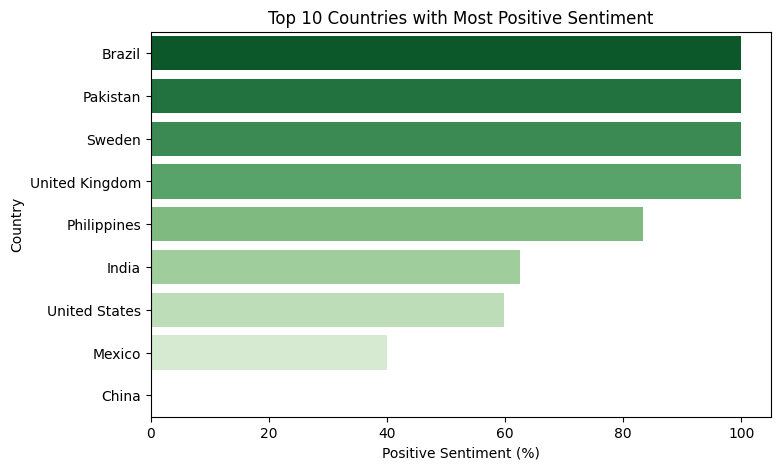

C:\Users\chand\AppData\Local\Temp\ipykernel_70932\4217475332.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




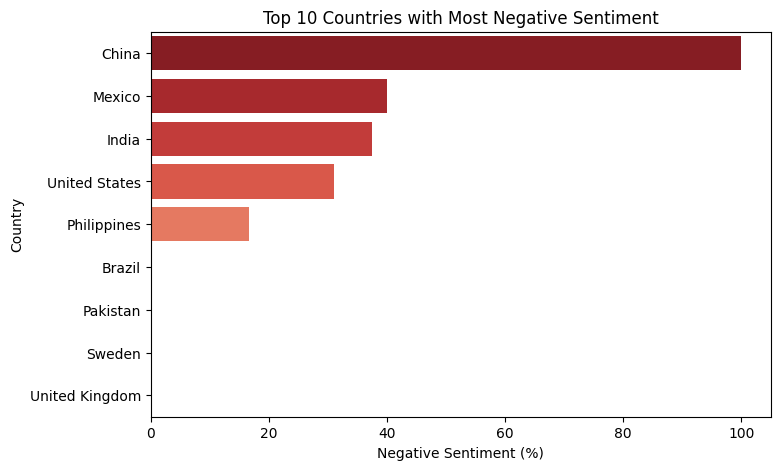

In [28]:
top_positive = sentiment_counts.sort_values('positive_percent', ascending=False).head(10)
top_negative = sentiment_counts.sort_values('negative_percent', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(y='country', x='positive_percent', data=top_positive, palette='Greens_r')
plt.title('Top 10 Countries with Most Positive Sentiment')
plt.xlabel('Positive Sentiment (%)')
plt.ylabel('Country')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(y='country', x='negative_percent', data=top_negative, palette='Reds_r')
plt.title('Top 10 Countries with Most Negative Sentiment')
plt.xlabel('Negative Sentiment (%)')
plt.ylabel('Country')
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix


Evaluation Metrics (Hybrid vs VADER):
              precision    recall  f1-score   support

    negative       0.58      0.84      0.68        63
     neutral       0.73      0.15      0.25       126
    positive       0.59      0.96      0.73       116

    accuracy                           0.60       305
   macro avg       0.63      0.65      0.56       305
weighted avg       0.65      0.60      0.52       305



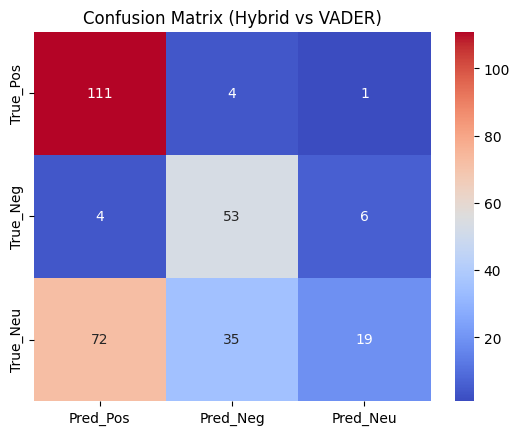

In [30]:
df['vader_sentiment'] = df['clean_post'].apply(lambda x: 'positive' if analyzer.polarity_scores(x)['compound']>0.05
                                               else 'negative' if analyzer.polarity_scores(x)['compound']<-0.05
                                               else 'neutral')
print("\nEvaluation Metrics (Hybrid vs VADER):")
print(classification_report(df['vader_sentiment'], df['sentiment']))

cm = confusion_matrix(df['vader_sentiment'], df['sentiment'], labels=['positive','negative','neutral'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Pred_Pos','Pred_Neg','Pred_Neu'],
            yticklabels=['True_Pos','True_Neg','True_Neu'])
plt.title('Confusion Matrix (Hybrid vs VADER)')
plt.show()

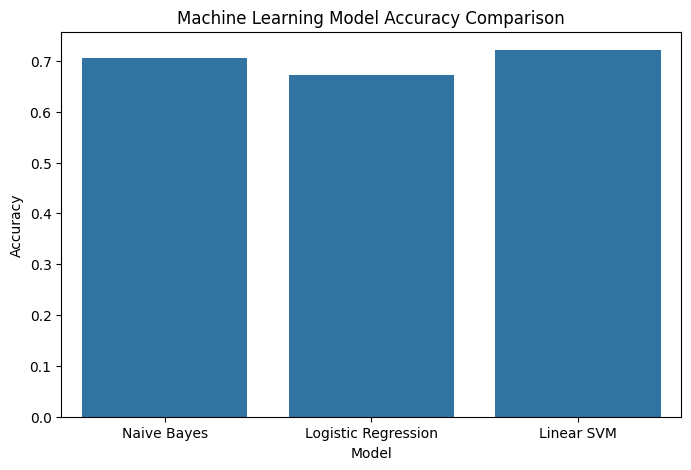

In [31]:
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=ml_results)
plt.title("Machine Learning Model Accuracy Comparison")
plt.show()

saving the results

In [32]:
output_path = "iphone17_sentiment_results_full.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Results saved to: {output_path}")


✅ Results saved to: iphone17_sentiment_results_full.csv


Summary

In [33]:
print("\n📊 SUMMARY:")
print("- Cleaned and preprocessed Reddit text data.")
print("- Performed hybrid (VADER + TextBlob) sentiment classification.")
print("- Evaluated performance against VADER baseline.")
print("- Created bar, pie, and map visualizations by country.")
print("- Generated word frequency summaries for each sentiment type.")
print("- Saved final labeled dataset for reporting.")


📊 SUMMARY:
- Cleaned and preprocessed Reddit text data.
- Performed hybrid (VADER + TextBlob) sentiment classification.
- Evaluated performance against VADER baseline.
- Created bar, pie, and map visualizations by country.
- Generated word frequency summaries for each sentiment type.
- Saved final labeled dataset for reporting.
